# Structure Learning

# Structure Learning

In [3]:
import warnings
from causalnex.structure import StructureModel

warnings.filterwarnings('ignore')

sm = StructureModel()

In [4]:
# Defino las relaciones entre atributos con conocimiento previo:
# Ejemplo, se que las lesiones de deportistas influyen en sus ausencias, no al revés.

sm.add_edges_from([
    ('health', 'absences'),
    ('health', 'G1')
])

In [5]:
# puedo ver los edges existentes con sm.edges
sm.edges

OutEdgeView([('health', 'absences'), ('health', 'G1')])

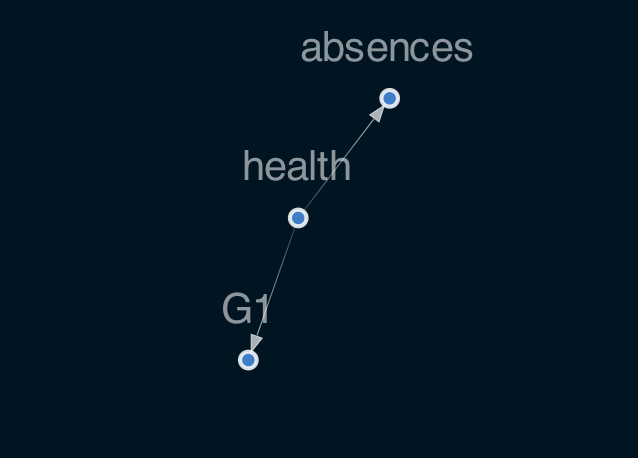

In [6]:
# mismo que arriba pero con gráfico

from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

viz = plot_structure(
    sm,
    graph_attributes={'scale': '0.5'},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK
)

Image(viz.draw(format='png'))

In [7]:
# A partir de cierto punto ya no sabes que variables influyen en que otras variables, y ahí es cuando le pasas el mando a CausalNex.
# Se utiliza el algoritmo NOTEARS, que se le puede pasar todo un df siempre que antes este se haya preprocesado.

import pandas as pd

data = pd.read_csv('student-por.csv', delimiter=';')
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


In [8]:
# En este caso dropeamos columnas como el sexo de la persona que representan información sensible.

drop_col = ['school', 'sex', 'age', 'Mjob', 'Fjob', 'reason', 'guardian']
data = data.drop(columns=drop_col)
data.head()

,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,U,GT3,A,4,4,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,U,GT3,T,1,1,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,U,LE3,T,1,1,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,U,GT3,T,4,2,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,U,GT3,T,3,3,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


In [9]:
# Luego pasamos los datos a numéricos.

import numpy as np

struct_data = data.copy()
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)

print(non_numeric_columns)

['address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

struct_data.head()

,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,1,0,0,4,4,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,4,0,11,11
1,1,0,1,1,1,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,2,9,11,11
2,1,1,1,1,1,1,2,0,1,0,0,0,1,1,1,0,4,3,2,2,3,3,6,12,13,12
3,1,0,1,4,2,1,3,0,0,1,0,1,1,1,1,1,3,2,2,1,1,5,0,14,14,14
4,1,0,1,3,3,1,2,0,0,1,0,0,1,1,0,0,4,3,2,1,2,5,0,11,13,13


In [11]:
# Luego aplicamos NOTEARS.

from causalnex.structure.notears import from_pandas

sm = from_pandas(struct_data)

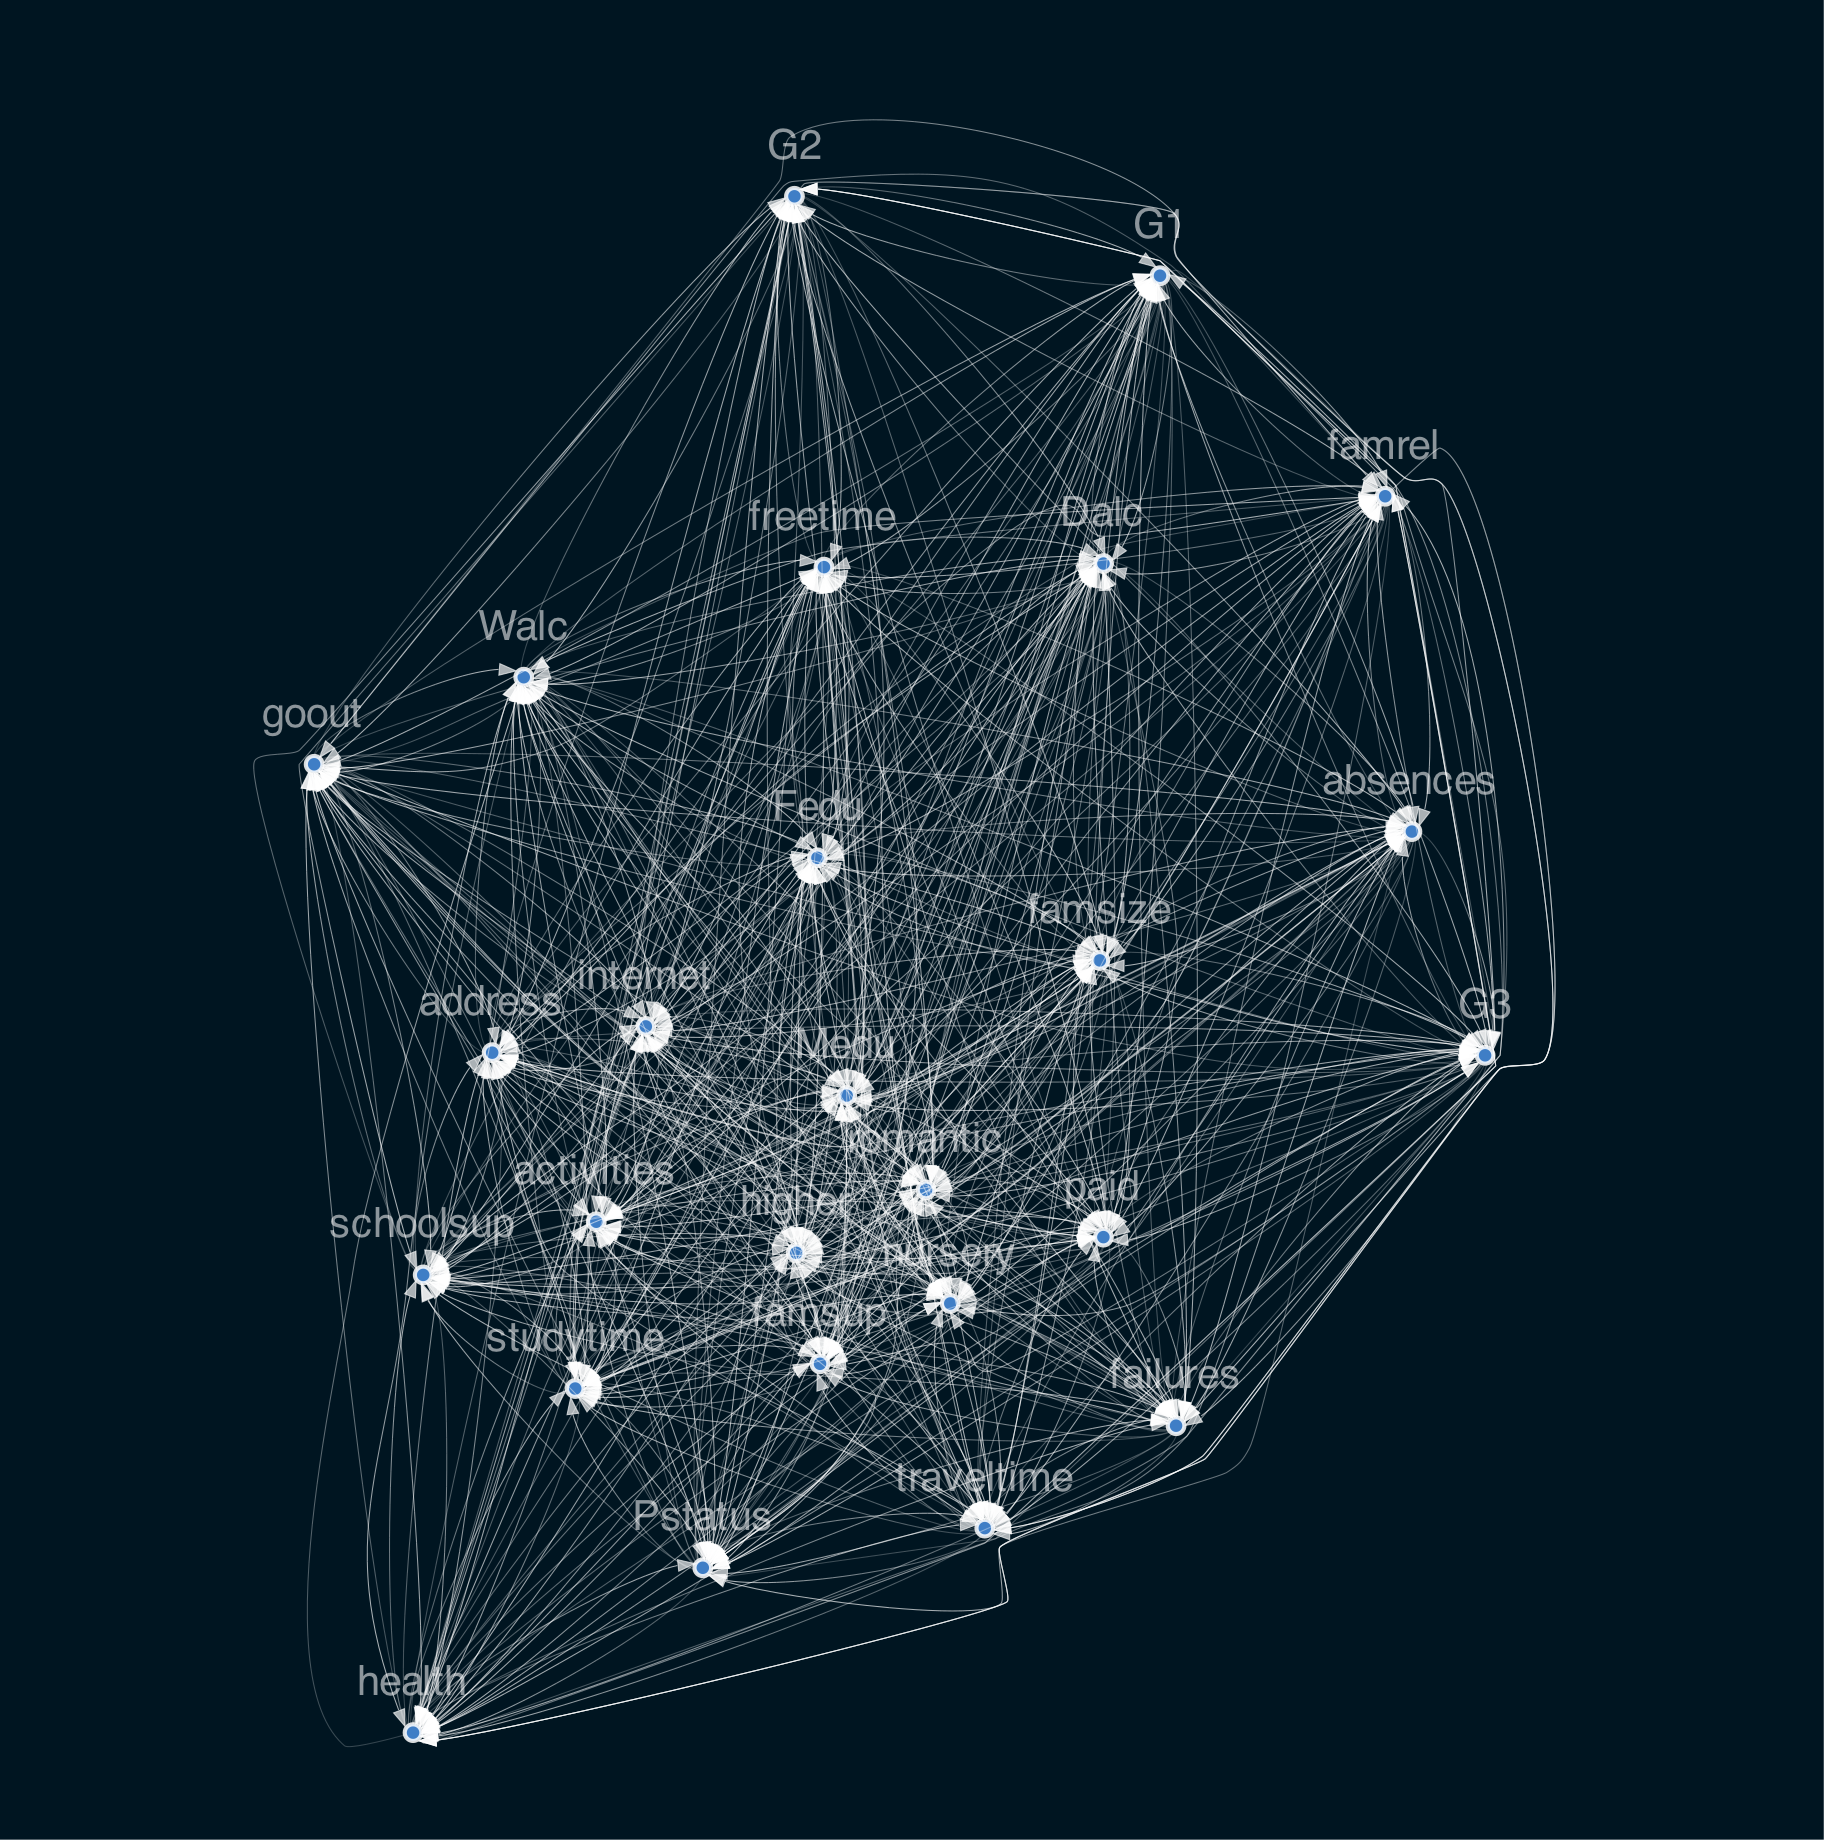

In [12]:
# Visualizamos los datos igual que antes.

viz = plot_structure(
    sm,
    graph_attributes={'scale': '0.5'},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog='fdp'
)

Image(viz.draw(format='png'))

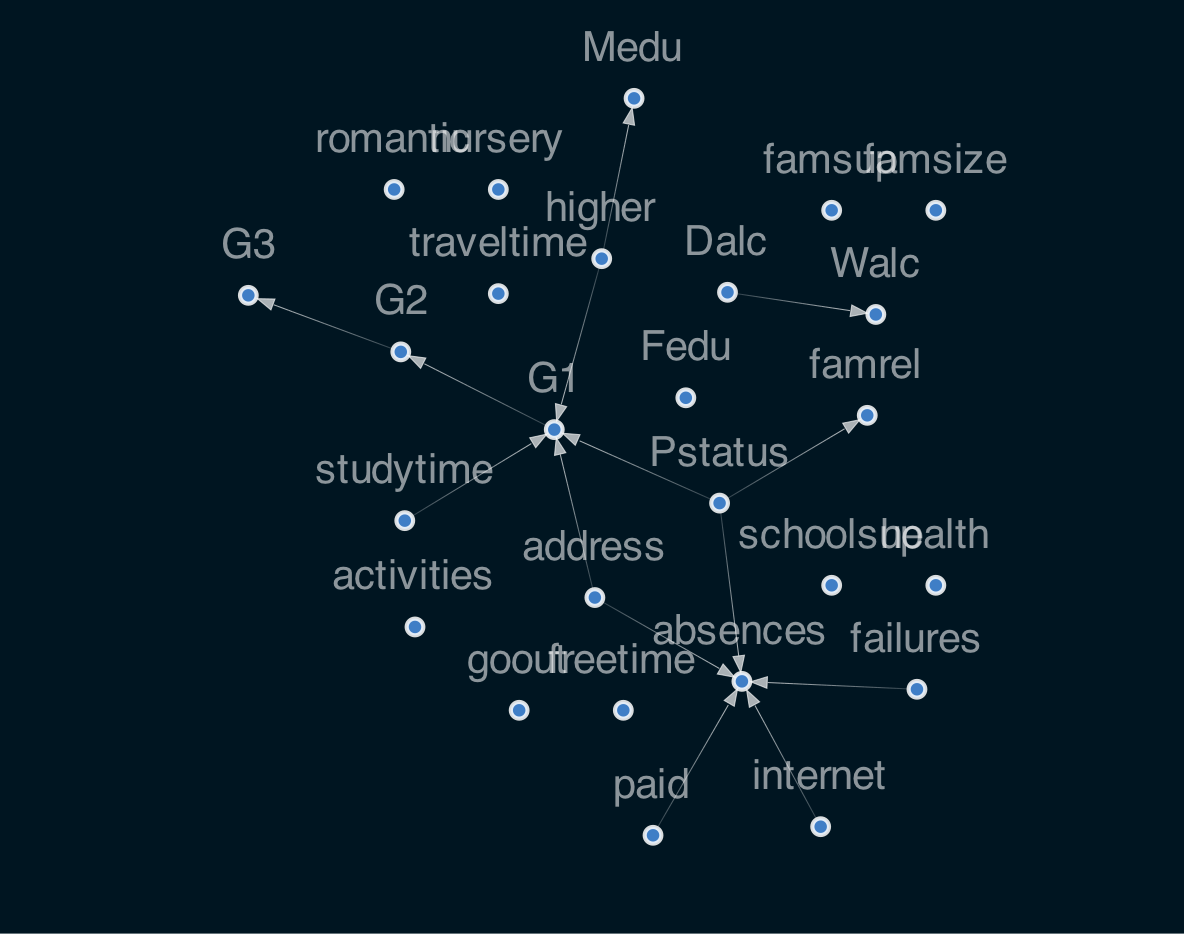

In [13]:
# Esto nos trae un gráfico completamente conectado porque según el algoritmo todo conecta con todo.
# La idea ahora es aplicar un mínimo aplicable para la existencia de una relación, como por ejemplo, 80%.

sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    graph_attributes={'scale': '0.5'},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [14]:
"""
Muchas de estas relaciones tienen sentido:
Pstatus afecta famrel - si los padres viven separados, se deteriora la calidad de la familia
internet afecta absences - con buen internet es probable que el estudiante decida faltar
studytime afecta G1 - si el estudiante estudia mucho es probable que tenga buenas notas

Sin embargo algunos edges parecerían estar mal
higher afecta Medu - esta relación probablemente esté al revés, no tiene sentido que un estudiante buscando
mejor educación motive a su madre a hacer lo mismo

Para ello podemos modificar este edge de manera manual
"""

sm = from_pandas(struct_data, tabu_edges=[('higher', 'Medu')], w_threshold=0.8)

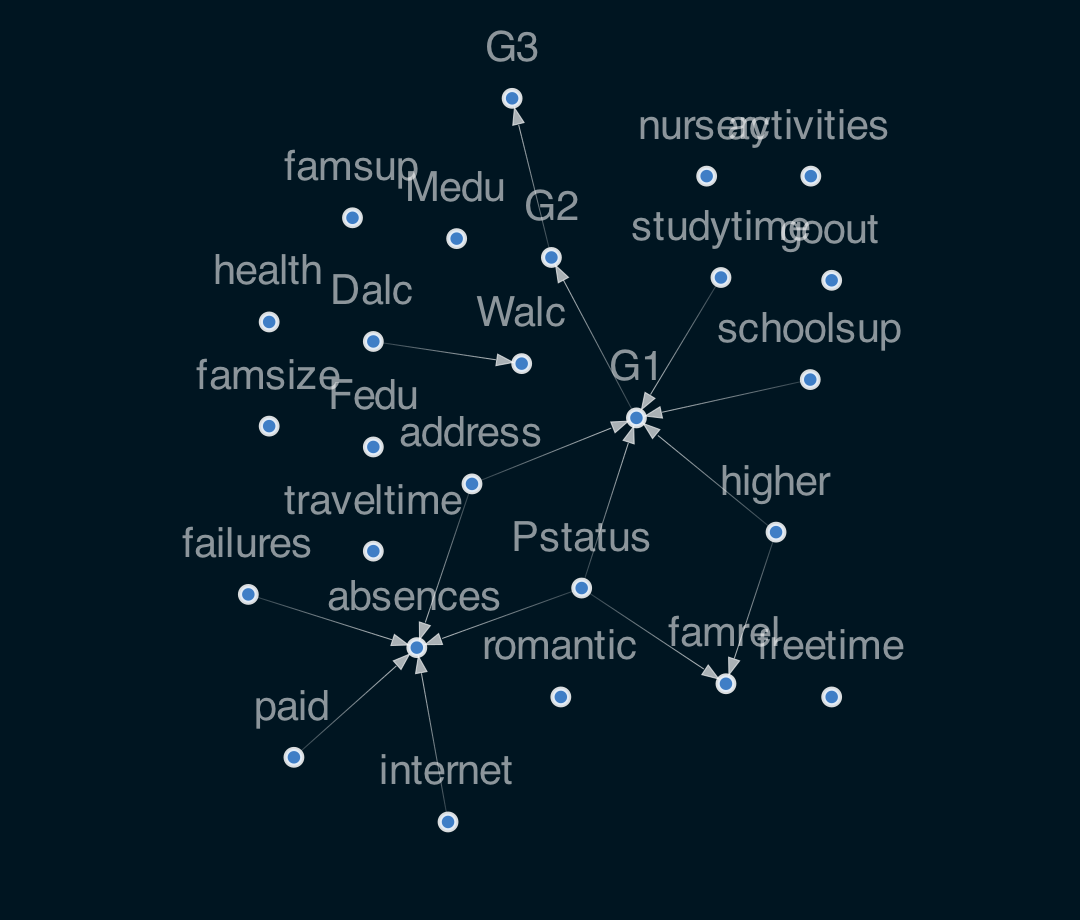

In [15]:
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    graph_attributes={'scale': '0.5'},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [16]:
# Podemos agregar conocimiento de la industria al modelo tras haber completado el modelado.
# Podemos borrar o agregar nuevos edges. Por ejemplo:

sm.add_edge('failures', 'G1')
sm.remove_edge('Pstatus', 'G1')
sm.remove_edge('address', 'G1')

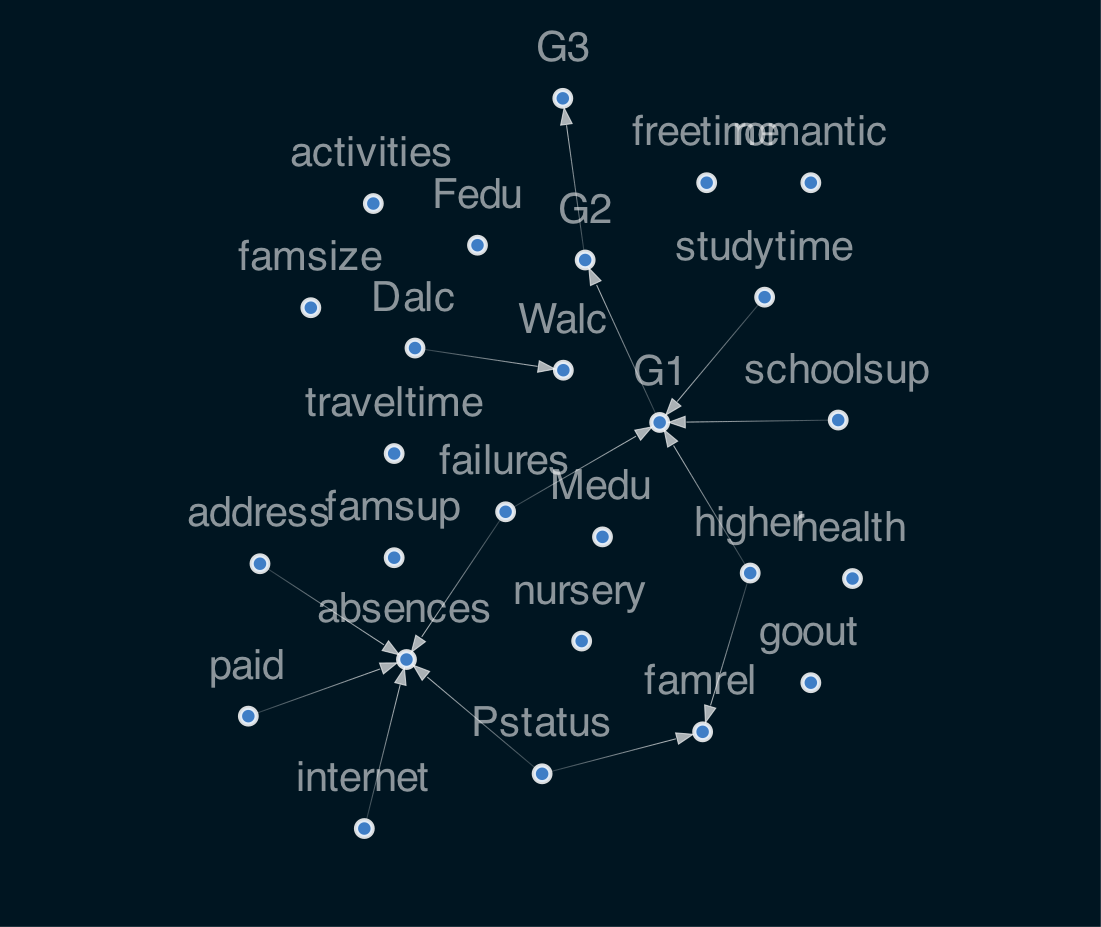

In [17]:
viz = plot_structure(
    sm,
    graph_attributes={'scale': '0.5'},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

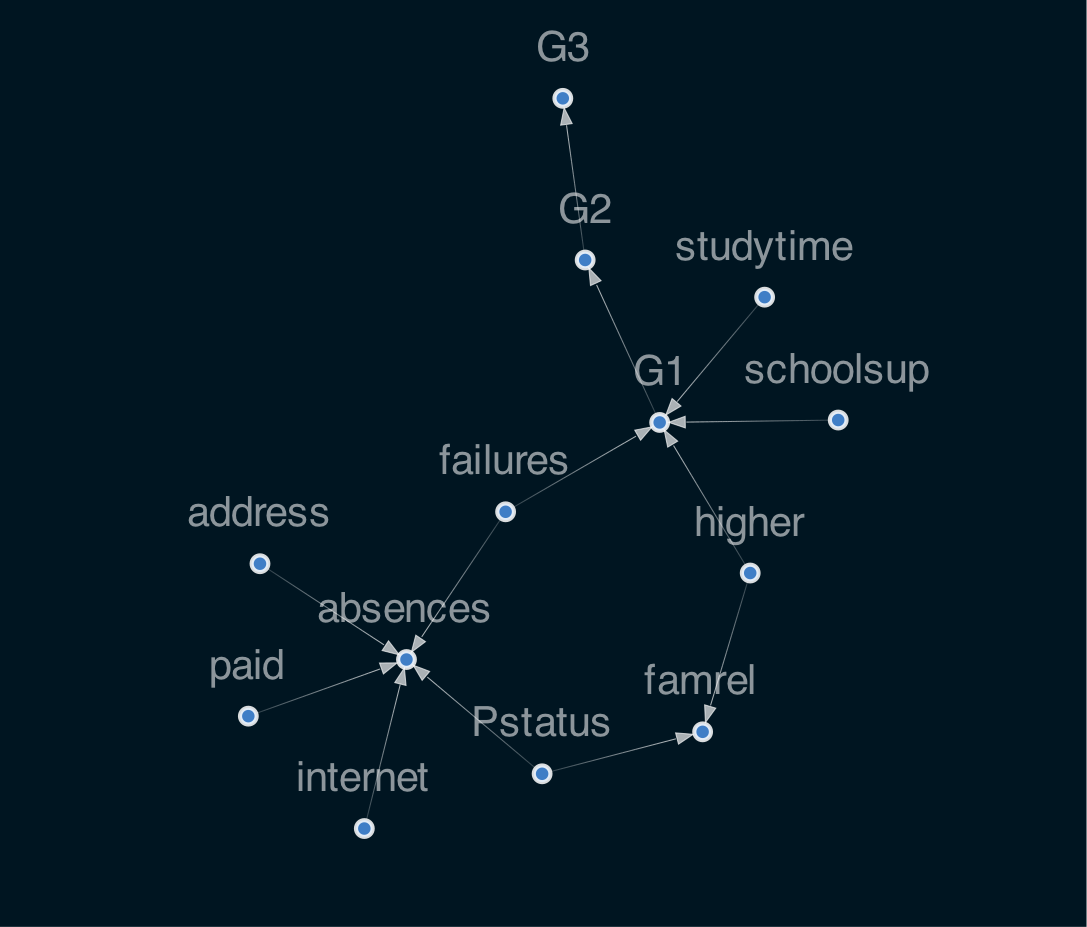

In [18]:
# Podemos ver que hay dos gráficos diferentes aca adentro. 'Dalc -> Walc' y el principal.
# Podemos quedarnos con el gráfico mas significativo con get_largest_subgraph()

sm = sm.get_largest_subgraph()
viz = plot_structure(
    sm,
    graph_attributes={'scale': '0.5'},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [19]:
# Podemos exportar el gráfico con ayuda de NetworkX.

import networkx as nx

nx.drawing.nx_pydot.write_dot(sm, 'graph.dot')

# Fitting the Conditional Distribution of the Bayesian Network

In [20]:
# Una vez que ya nos decidimos sobre la estructura del modelo, empezamos a trabajar con Bayesian Networks.

from causalnex.network import BayesianNetwork

bn = BayesianNetwork(sm)

In [21]:
# BayesianNetwork solo soporta variables discretas. Modelos con muchas variables por lo general tienden al 
# sobreajuste y mal desempeño en la práctica.

# CausalNex ofrece algunos métodos para ayudar a discretizar las variables del dataset en el que se trabaja.
# Para mejorar el modelo, se puede reducir la cardinalidad de las variables por medio de simplificar las categorías
# existentes. Por ejemplo, todo studytime mayor a 2 se unifica en "long-studytime"

discretised_data = data.copy()

data_vals = {col: data[col].unique() for col in data.columns}

failures_map = {v: 'no-failure' if v == [0]
                else 'have-failure' for v in data_vals['failures']}
studytime_map = {v: 'short-studytime' if v in [1,2]
                 else 'long-studytime' for v in data_vals['studytime']}

In [22]:
discretised_data['failures'] = discretised_data['failures'].map(failures_map)
discretised_data['studytime'] = discretised_data['studytime'].map(studytime_map)

In [23]:
# Podemos usar el objeto Discretiser para discretizar las variables cuantitativas. 
# El método 'fixed'...

from causalnex.discretiser import Discretiser

discretised_data['absences'] = Discretiser(method="fixed", numeric_split_points=[1, 10]).transform(discretised_data['absences'].values)
discretised_data['G1'] = Discretiser(method="fixed", numeric_split_points=[10]).transform(discretised_data['G1'].values)
discretised_data['G2'] = Discretiser(method="fixed", numeric_split_points=[10]).transform(discretised_data['G2'].values)
discretised_data['G3'] = Discretiser(method="fixed", numeric_split_points=[10]).transform(discretised_data['G3'].values)

In [24]:
# Aplicamos etiquetas para mejorar legibilidad.

absences_map = {0: 'No-absence', 1: 'Low-absence', 2: 'High-absence'}

G1_map = {0: 'Fail', 1: 'Pass'}
G2_map = {0: 'Fail', 1: 'Pass'}
G3_map = {0: 'Fail', 1: 'Pass'}

discretised_data['absences'] = discretised_data['absences'].map(absences_map)
discretised_data['G1'] = discretised_data['G1'].map(G1_map)
discretised_data['G2'] = discretised_data['G2'].map(G2_map)
discretised_data['G3'] = discretised_data['G3'].map(G3_map)

In [25]:
# Empezamos a trabajar con el modelo.

from sklearn.model_selection import train_test_split

train, test = train_test_split(discretised_data, train_size=0.1, test_size=0.1, random_state=7)

# Model Probability

In [26]:
# El primer paso es especificar todos los estados posibles para un nodo. Lo ideal es utilizar todo
# el dataset entero, no solo el de train, ya que puede existir un caso presente en test no presente
# en train.

bn = bn.fit_node_states(discretised_data)

In [29]:
# El método fit_cpds acepta un dataset y aprende las distribuciones de probabilidad condicional
# (conditional probability distributions) de cada nodo.

bn = bn.fit_cpds(train, method='BayesianEstimator', bayes_prior='K2')

In [30]:
# Luego puedo examinar los cpds, que es un diccionario de cada nodo.

bn.cpds['G1']

failures    have-failure                  ...     no-failure                
higher                no                  ...            yes                
schoolsup             no                  ...            yes                
studytime long-studytime short-studytime  ... long-studytime short-studytime
G1                                        ...                               
Fail                 0.5             0.8  ...       0.333333             0.5
Pass                 0.5             0.2  ...       0.666667             0.5

[2 rows x 16 columns]

In [48]:
# Puedo predecir también. Asumamos que viene un caso así.

discretised_data.loc[9]

address                     U
famsize                   GT3
Pstatus                     T
Medu                        3
Fedu                        4
traveltime                  1
studytime     short-studytime
failures           no-failure
schoolsup                  no
famsup                    yes
paid                       no
activities                yes
nursery                   yes
higher                    yes
internet                  yes
romantic                   no
famrel                      5
freetime                    5
goout                       1
Dalc                        1
Walc                        1
health                      5
absences           No-absence
G1                       Pass
G2                       Pass
G3                       Pass
Name: 9, dtype: object

In [33]:
predictions = bn.predict(discretised_data, 'G1')

In [46]:
print(f'The prediction is {predictions.loc[9, "G1_prediction"]}')

The prediction is Pass


In [47]:
# Comparado con la verdad...

print(f'The ground truth is {discretised_data.loc[9, "G1"]}')

The ground truth is Pass


# Model Quality

In [49]:
# Para evaluar la calidad del modelo, CausalNex ofrece dos diferentes enfoques: reporte de clasificación
# y Receiver Operating Characteristics (ROC) / Area Under the ROC Curve (AUC).

# Classification Report:

from causalnex.evaluation import classification_report

classification_report(bn, test, 'G1')

{'G1_Fail': {'precision': 0.5,
  'recall': 0.25,
  'f1-score': 0.3333333333333333,
  'support': 12},
 'G1_Pass': {'precision': 0.847457627118644,
  'recall': 0.9433962264150944,
  'f1-score': 0.8928571428571428,
  'support': 53},
 'accuracy': 0.8153846153846154,
 'macro avg': {'precision': 0.673728813559322,
  'recall': 0.5966981132075472,
  'f1-score': 0.613095238095238,
  'support': 65},
 'weighted avg': {'precision': 0.7833116036505866,
  'recall': 0.8153846153846154,
  'f1-score': 0.7895604395604395,
  'support': 65}}

In [50]:
# Dado que hay buena precision pero también alto recall, podemos estar seguros de los casos positivos, no 
# tanto de los negativos. Es posible que esta falla se deba a nexos faltantes en nuestra estructura.

# ROC / AUC

from causalnex.evaluation import roc_auc

roc, auc = roc_auc(bn, test, 'G1')
print(auc)

0.9048520710059171


In [51]:
# El valor del auc es alto, lo que nos da confianza en el modelo.

# Querying Marginals

In [52]:
# Una vez que estamos convencidos del modelo, queda empezar a buscar inferencias en los atributos.

bn = bn.fit_cpds(discretised_data, method='BayesianEstimator', bayes_prior='K2')

In [53]:
from causalnex.inference import InferenceEngine

ie = InferenceEngine(bn)
marginals = ie.query()
marginals['G1']

{'Fail': 0.25260687281677224, 'Pass': 0.7473931271832277}

In [54]:
# Esto nos dice que P(G1=Pass) = ~0.75. Para corroborar que eso es cierto, podríamos contar el total
# de Pass sobre el total del dataset; debería coincidir.

import numpy as np

labels, counts = np.unique(discretised_data['G1'], return_counts=True)
list(zip(labels, counts))

[('Fail', 157), ('Pass', 492)]

In [55]:
# Puedo también buscar la probabilidad condicional de otros nodos del grafo. Las observaciones se pueden
# hacer con cualquier nodo ya que se propagan por todo el mapa.

marginals_short = ie.query({'studytime': 'short-studytime'})
marginals_long = ie.query({'studytime': 'long-studytime'})
print('Marginal G1 | Short Studytime', marginals_short['G1'])
print('Marginal G1 | Long Studytime', marginals_long['G1'])

Marginal G1 | Short Studytime {'Fail': 0.2776556433482524, 'Pass': 0.7223443566517477}
Marginal G1 | Long Studytime {'Fail': 0.15504850337837614, 'Pass': 0.8449514966216239}


# Do Calculus

In [56]:
# Updating a Node Distribution

# Podemos aplicar modificaciones arbitrarias a nuestros nodos para preguntarnos 'what if?'
# En este caso, que pasaría si el 100% de los estudiantes deciden perseguir educación de grado

print('distribution before do', ie.query()['higher'])
ie.do_intervention('higher', {'yes': 1.0, 'no': 0.0})
print('distribution after do', ie.query()['higher'])

distribution before do {'no': 0.10752688172043011, 'yes': 0.8924731182795698}
distribution after do {'no': 0.0, 'yes': 0.9999999999999998}


In [57]:
# Al terminar los estudios hay que resetear el nodo.

ie.reset_do('higher')

In [58]:
# La idea del do es poder ver que pasaría con las probabilidades si se modifica algún atributo.

print('marginal G1', ie.query()['G1'])
ie.do_intervention('higher', {'yes': 1.0, 'no': 0.0})
print('updated marginal G1', ie.query()['G1'])

marginal G1 {'Fail': 0.25260687281677224, 'Pass': 0.7473931271832277}
updated marginal G1 {'Fail': 0.20682952942551894, 'Pass': 0.7931704705744809}
